In [1]:
import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
os.getcwd()

'/content'

In [6]:
os.listdir('/content')

['.config', 'sample_data']

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
data_path = "/content/drive/My Drive/Hands on Deep Learning/mask_dataset_preprocessing"
os.path.exists(data_path)

True

In [13]:
def DataList(data_path):
  img_list, data_label, data_types = [], [], []
  class_path = ""
  for root, dirs, files in os.walk(data_path):
    label = root.split("/")[-1]
    types = root.split("/")[-2]
    if types in ["train", "valid", "test"]:
      for file in files:
        if file.find("checkpoint")==-1:
          if file[-3:]=="csv":
            class_path = os.path.join(root, file)
          else:
            img_list.append(os.path.join(root, file))
            data_label.append(label)
            data_types.append(types)

  data_list = pd.DataFrame({"img_path":img_list, "label_name":data_label, "types":data_types})
  
  if class_path != "":
    class_map = pd.read_csv(class_path, header=None)
    class_map = dict(class_map.values)
  else:
    class_map = data_list[data_list["types"]=="train"]["label_name"].unique()
    class_map = {label: str(i) for i, label in enumerate(class_map)}
  print(class_map)

  data_list["label"] = data_list["label_name"].map(class_map)
  
  train_list = data_list[data_list["types"]=="train"][["img_path", "label_name", "label"]].copy()
  valid_list = data_list[data_list["types"]=="valid"][["img_path", "label_name", "label"]].copy()
  test_list = data_list[data_list["types"]=="test"][["img_path", "label_name", "label"]].copy()

  return train_list, valid_list, test_list, class_map

In [14]:
train_list, valid_list, test_list, class_map = DataList(data_path)

{'mask_less': '0', 'mask_improperly': '1', 'mask_properly': '2'}


In [15]:
train_list.head()

,img_path,label_name,label
0,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
1,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
2,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
3,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
4,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0


## 如果資料不平衡...
[**way1.**](#way1) 把訓練資料中每個類別數量變成一樣多</br>
[**way2.**](#way2) 針對訓練資料中類別少的類別犯錯給比較重的懲罰，進行學習



#### way1. 把每個類別變的一樣多
- 請執行底下 4 個cells
- 如果要執行 way2，請""別""執行底下 4 個 cells

[0 1 2]
[344 102 213]


<BarContainer object of 3 artists>

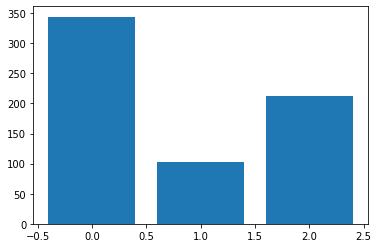

In [16]:
unique, counts = np.unique(train_list["label"].values, return_counts=True)
unique = unique.astype(np.int_)
print(unique)
print(counts)
plt.bar(unique, counts)

In [17]:
max_class_name, max_class_num = unique[counts.argmax()], counts.max()
max_class_name, max_class_num

(0, 344)

In [18]:
from sklearn.utils import shuffle

sampling_ind = []
for class_name, class_num in zip(unique, counts):
  tmp_data = train_list[train_list["label"]==str(class_name)]
  tmp_ind = list(tmp_data.index)
  sampling_ind.extend(tmp_ind)
  if class_num < max_class_num:
    mod_num, res_num = max_class_num//class_num-1, max_class_num%class_num
    for _ in range(mod_num):
      sampling_ind.extend(tmp_ind)
    if res_num != 0:
      sampling_ind.extend(shuffle(tmp_ind)[:res_num])

train_list = train_list.loc[sampling_ind]

<BarContainer object of 3 artists>

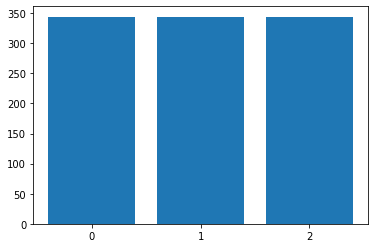

In [19]:
unique, counts = np.unique(train_list["label"].values, return_counts=True)
plt.bar(unique, counts)

#### way2. 針對訓練資料中類別少的類別犯錯給比較重的懲罰，進行學習
- 請執行底下 2 個cells
- 計算出 class_weights 比例，以便 model.fit 時，加入 loss 一同計算



In [ ]:
unique, counts = np.unique(train_list["label"].values, return_counts=True)
print("unique ", unique)
print("counts: ", counts)

unique  ['0' '1' '2' '3']
counts:  [10 13  8 10]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                      unique,
                      train_list["label"].values)
print(class_weights)

[1.025      0.78846154 1.28125    1.025     ]


## Modeling

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [22]:
num_classes = train_list["label"].unique().shape[0]
num_classes

3

In [23]:
img_shape = (224, 224)
batch_size = 16

In [24]:
def num_steps_per_epoch(data_generator, batch_size):
  if data_generator.n % batch_size==0:
    return data_generator.n//batch_size
  else:
    return data_generator.n//batch_size + 1

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### 如果你需要的只是測試，只需要執行到這邊就可以了
- 請從""大考時間到""再開始執行</br>
[Testing-大考時間到](#Testing-大考時間到)--------------------------------------------------------------------------------

In [26]:
train_datagen = ImageDataGenerator(
                    rotation_range=5,
                    horizontal_flip=True,
                    vertical_flip=False,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function=preprocess_input
                    
                    )
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
                              dataframe=train_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical')
valid_generator = valid_datagen.flow_from_dataframe(
                              dataframe=valid_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical',
                              shuffle=False)


Found 1032 validated image filenames belonging to 3 classes.
Found 141 validated image filenames belonging to 3 classes.


In [28]:
pre_model = ResNet50(weights='imagenet', input_shape=(img_shape[0], img_shape[1], 3), include_top=False)

x = layers.GlobalAveragePooling2D()(pre_model.output)
x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

94773248/94765736 [==============================] - 1s 0us/step


In [29]:
model = keras.models.Model(inputs=pre_model.inputs, outputs=outputs)

In [30]:
model_dir = os.path.join(data_path, 'model-logs')
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)


callbacks_list = [model_mckp, earlystop]

In [31]:
lr = 1e-4
num_epochs = 10

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [32]:
# model.summary()

### 1st run: 固定前面，訓練 Dense Layer
- 因為 Dense Layer 現在是 initial 所以現在需要大一點的 learning rate 

In [33]:
lr = 1e-4
optimizer = keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [34]:
pre_model.trainable = False
# model.summary()

# pre_model.trainable = True
# for each_layer in pre_model.layers[:-5]:
#     each_layer.trainable = False

- 如果要加入 class_weights 進行訓練，把 # 拿掉即可

In [ ]:
class_weights = {i: value for i, value in enumerate(class_weights)}

In [35]:
history = model.fit_generator(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  # class_weight=class_weights,
                  callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
65/65 [==============================] - 179s 3s/step - loss: 0.5749 - accuracy: 0.7539 - val_loss: 0.5969 - val_accuracy: 0.7730
Epoch 2/10
65/65 [==============================] - 23s 359ms/step - loss: 0.1468 - accuracy: 0.9535 - val_loss: 1.1065 - val_accuracy: 0.7943
Epoch 3/10
65/65 [==============================] - 23s 361ms/step - loss: 0.0956 - accuracy: 0.9651 - val_loss: 0.6250 - val_accuracy: 0.8582
Epoch 4/10
65/65 [==============================] - 20s 312ms/step - loss: 0.0219 - accuracy: 0.9961 - val_loss: 0.8920 - val_accuracy: 0.8369
Epoch 00004: early stopping


### 2nd run: 鬆開部分前面，一起訓練
- 因為部分卷基層和 Dense Layer 已經不錯，只需要微調 Fine Tune，Learnig rate 須設小一點
- 選擇 1st run 訓練結果中，小考成績最高的那一次，進行 2nd run</br>
  (如果最後一次是最好的，就不用執行底下的 cell)


In [36]:
# try:
#   import tensorflow.keras.backend as K
#   K.clear_session()
#   model_path = model_dir + '/{}-best-model.h5'.format('basic_model')
#   model = keras.models.load_model(model_path)
# except:
#   pass

In [37]:
lr = 1e-6
optimizer = keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [38]:
pre_model.trainable = True
for each_layer in pre_model.layers[:-5]:
  each_layer.trainable = False

In [39]:
history = model.fit_generator(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  # class_weight=class_weights,
                  callbacks=callbacks_list)

Epoch 1/10
65/65 [==============================] - 18s 277ms/step - loss: 0.0261 - accuracy: 0.9903 - val_loss: 0.8867 - val_accuracy: 0.8369
Epoch 2/10
65/65 [==============================] - 17s 264ms/step - loss: 0.0163 - accuracy: 0.9932 - val_loss: 0.8813 - val_accuracy: 0.8440
Epoch 3/10
65/65 [==============================] - 17s 263ms/step - loss: 0.0195 - accuracy: 0.9932 - val_loss: 0.8766 - val_accuracy: 0.8440
Epoch 4/10
65/65 [==============================] - 17s 263ms/step - loss: 0.0149 - accuracy: 0.9932 - val_loss: 0.8717 - val_accuracy: 0.8440
Epoch 5/10
65/65 [==============================] - 17s 261ms/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 0.8674 - val_accuracy: 0.8440
Epoch 6/10
65/65 [==============================] - 17s 261ms/step - loss: 0.0166 - accuracy: 0.9952 - val_loss: 0.8641 - val_accuracy: 0.8440
Epoch 7/10
65/65 [==============================] - 17s 261ms/step - loss: 0.0125 - accuracy: 0.9952 - val_loss: 0.8601 - val_accuracy: 0.8511

- 依照你的需求看須不要存最後一次模型結果，最後一次不一定是最好的，但是可以留一份紀錄這樣

In [40]:
# model_path = model_dir + '/{}-last-model-stage2.h5'.format('basic_model')
# model.save(model_path)

## Testing 大考時間到

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [42]:
try:
  import tensorflow.keras.backend as K
  K.clear_session()
  model_dir = os.path.join(data_path, 'model-logs')
  model_path = model_dir + '/{}-best-model.h5'.format('basic_model')
  model = keras.models.load_model(model_path)
except:
  model_path = model_dir + '/{}-best-model.h5'.format('basic_model')
  model = keras.models.load_model(model_path)

In [43]:
batch_size = 16

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
                              dataframe=test_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode=None,
                              shuffle=False)

test_steps = num_steps_per_epoch(test_generator, batch_size)

Found 141 validated image filenames.


In [44]:
y_test = test_list["label"].values.astype(np.int_)

In [45]:
y_test_predprob = model.predict_generator(test_generator)
y_test_pred = y_test_predprob.argmax(-1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


accuracy_score: 0.830


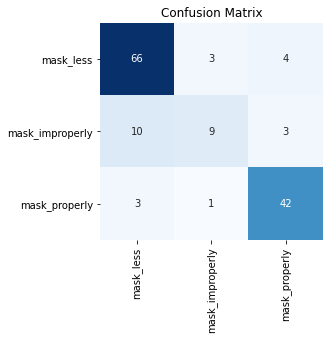

In [47]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")

plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False,
      xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title("Confusion Matrix")
plt.show()